In [12]:
## import modules 
from updated_utilities import unconverged_scf,force_encut_conv,energy_encut_conv
from updated_utilities import slab_adslab_encut_Econv,sigma_Econv, kpt_convergence
# import libraries
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Adeesh data from the perspecive paper
df_val = pd.read_csv("gemnet-relaxations.csv", index_col=0)
df_val["error"] = np.abs(df_val["energy dE [eV]"] - df_val["genmet_T_predE"])
# sort error column in descending order
df_val.sort_values(by=['error'], inplace=True, ascending=False)

In [3]:
## load the mappings stored from previous experiments
with open('experiments_uuid_mappings.pickle', 'rb') as read_file:
    updated_mappings = pickle.load(read_file)
df  = pd.DataFrame(updated_mappings).transpose()
# make a dataframe from the mappings and query for the system of choice
df.rename(columns={'class': 'cat_class'}, inplace=True)

In [4]:
# remove unfinished calculations
df = df.query("final_energy.isnull()==False")
# get only encut calcualtions
df = df.query("sigma==0.2&k_point_multiplier==40")

In [5]:
# check for scf convergence
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 17949/17949 [00:01<00:00, 11187.87it/s]


In [14]:
def energy_encut_conv(df,encut_values, material):
    all_final_energies = {}
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for encut in encut_values: 
                final_energies.append(df_sid.query(f"encut=={encut}")['final_energy'].values[0])
            all_final_energies[sid] = final_energies
            plt.plot(encut_values, np.array(final_energies) - final_energies[-1], "-o",)
        except IndexError as exception:
            pass
#             print(f"{sid} has some unfinshed calculations")
    plt.title(f"{material} energy convergence vs encut")       
    plt.xlabel("encut (ev)")
    plt.ylabel("Energy convergence error (ev)");
    return all_final_energies

100%|██████████| 81/81 [00:00<00:00, 178.37it/s]


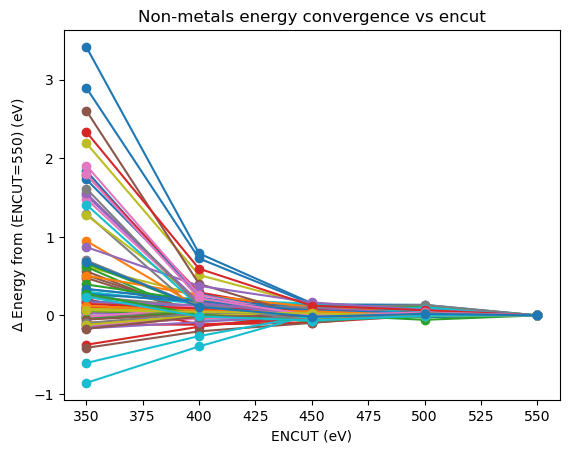

In [15]:
df_nonmetals = df_val.query("material_type == 'nonmetals'")
# get the best 100 systems
sids = df_nonmetals.iloc[:101]["ID"].values
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
nonmetals_energy_encut = energy_encut_conv(worst_nonmetals_df_adslab,
                                          encut_values=[350,400,450,500,550],material="Non-metals")
plt.xlabel("ENCUT (eV)")
plt.ylabel("$\Delta$ Energy from (ENCUT=550) (eV)");

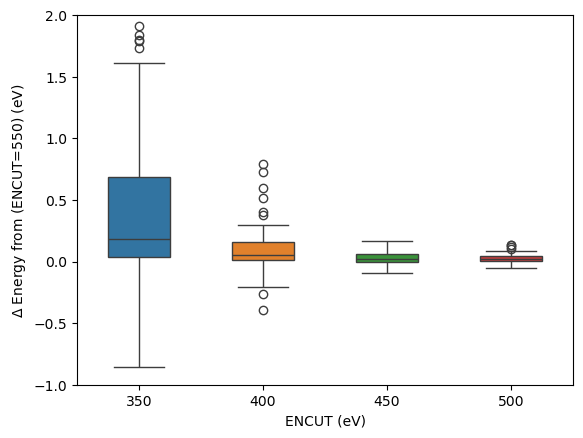

In [16]:
new_fig = np.array(list(nonmetals_energy_encut.values()))-np.array(list(nonmetals_energy_encut.values()))[:,-1].reshape(-1,1)
new_fig_df = pd.DataFrame({"350":new_fig[:,0],
                          "400":new_fig[:,1],
                          "450":new_fig[:,2],
                          "500":new_fig[:,3],})
sns.boxplot(data = new_fig_df ,widths=0.5)
plt.xlabel("ENCUT (eV)")
plt.ylabel(r"$\Delta$ Energy from (ENCUT=550) (eV)")
plt.ylim((-1,2));

## SIGMA

In [41]:
## load the mappings stored from previous experiments
with open('experiments_uuid_mappings.pickle', 'rb') as read_file:
    updated_mappings = pickle.load(read_file)
df  = pd.DataFrame(updated_mappings).transpose()
# make a dataframe from the mappings and query for the system of choice
df.rename(columns={'class': 'cat_class'}, inplace=True)

In [42]:
## Adeesh data from the perspecive paper
df_val = pd.read_csv("gemnet-relaxations.csv", index_col=0)
df_val["error"] = np.abs(df_val["energy dE [eV]"] - df_val["genmet_T_predE"])
# sort error column in descending order
df_val.sort_values(by=['error'], inplace=True, ascending=False)

In [43]:
df_nonmetals = df_val.query("material_type == 'nonmetals'")
sids = list(df_nonmetals.iloc[0:101]["ID"].values)

In [44]:
# remove unfinished calculations
df = df.query("final_energy.isnull()==False")
# get only sigma calcualtions
df = df.query("encut==350&k_point_multiplier==40")

In [45]:
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 20289/20289 [00:01<00:00, 10785.61it/s]


  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 65/65 [00:00<00:00, 174.67it/s]


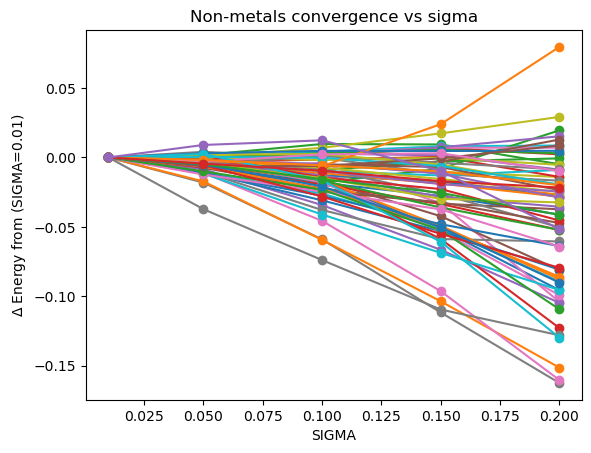

In [46]:
best_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
nonmetals_energy_sigma = sigma_Econv(best_nonmetals_df_adslab,sigma_values=[0.2,0.15,0.1,0.05,0.01]
                                  ,material="Non-metals")
plt.xlabel("SIGMA")
plt.ylabel(r"$\Delta$ Energy from (SIGMA=0.01)");

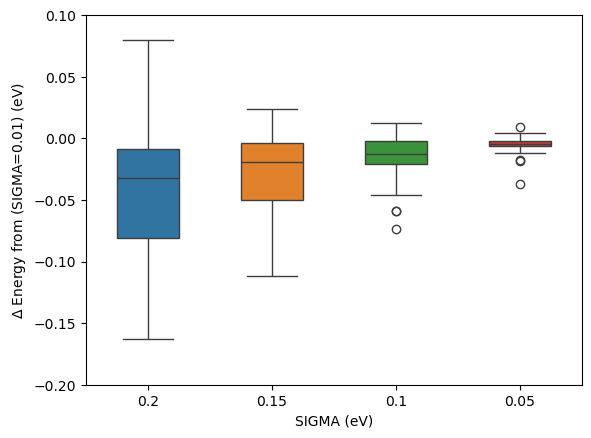

In [47]:
new_fig = nonmetals_energy_sigma-nonmetals_energy_sigma[:,-1].reshape(-1,1)
new_fig_df = pd.DataFrame({"0.2":new_fig[:,0],
                          "0.15":new_fig[:,1],
                          "0.1":new_fig[:,2],
                          "0.05":new_fig[:,3],
                          })
ax = sns.boxplot(data = new_fig_df ,widths=0.5)
ax.set_ylim((-0.2,0.1))
plt.xlabel("SIGMA (eV)")
plt.ylabel(r"$\Delta$ Energy from (SIGMA=0.01) (eV)");